In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dataset = MNIST(root = 'MNIST_data/', download = False, transform = ToTensor())

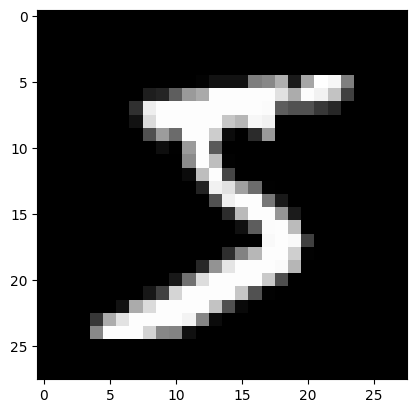

In [3]:
import matplotlib.pyplot as plt
img, label = dataset[0]
plt.imshow(img[0], cmap = 'gray')

In [4]:
def split_indices(n, val_pct):
    nval = int(n*val_pct)
    indxs = np.random.permutation(n)
    return indxs[nval:], indxs[:nval]

In [5]:
train_indices, val_indices = split_indices(len(dataset), 0.2)

In [6]:
print(len(train_indices), len(val_indices))

48000 12000


In [7]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size,sampler= train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler = val_sampler)



In [8]:
import torch.nn.functional as F
import torch.nn as nn

In [9]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size,out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
    def forward(self, xb):
        xb = xb.view(xb.size(0),-1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [10]:
input_size = 784
num_classes = 10
hidden_size = 32

model = MnistModel(input_size, hidden_size, num_classes)


In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break
print('outputs.shape', outputs.shape)
print('sample_outputs:\n', F.softmax(outputs)[:2].data)

Loss: 2.3030054569244385
outputs.shape torch.Size([100, 10])
sample_outputs:
 tensor([[0.0965, 0.1074, 0.1093, 0.0952, 0.0847, 0.1169, 0.0982, 0.0942, 0.0959,
         0.1017],
        [0.0996, 0.1075, 0.1111, 0.0988, 0.0890, 0.1042, 0.0988, 0.0891, 0.1086,
         0.0933]])


C:\Users\aryap\AppData\Local\Temp\ipykernel_37440\4167422373.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('sample_outputs:\n', F.softmax(outputs)[:2].data)


In [13]:
torch.cuda.is_available()

True

In [14]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking = True)

In [17]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break


torch.Size([100, 1, 28, 28])
cuda:0


In [18]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device= device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [19]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device )

In [20]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.sum(preds == labels).item()/len(preds)

In [22]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  preds = model(xb)
  loss = loss_func(preds, yb)

  if opt:
    loss.backward()
    opt.step()
    opt.zero_grad()
  metric_result=None
  if metric:
    metric_result = metric(preds, yb)
  return loss.item(), len(xb), metric_result

In [23]:
def evaluate(model, loss_func, valid_dl, metric = None):
  with torch.no_grad():
    results = [loss_batch(model, loss_func, xb, yb, metric=metric) for xb, yb in valid_dl]

    losses, nums, metrics = zip(*results)

    total = np.sum(nums)

    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None
    if metric:
      avg_metric = np.sum(np.multiply(metrics, nums))/total
    return avg_loss, total, avg_metric

In [24]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric = None, opt_fn = None):
  losses, metrics = [], []
  if not opt_fn:
    opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(), lr = lr)

  for epoch in range(epochs):
    for xb, yb in train_dl:
      loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result
    losses.append(val_loss)
    metrics.append(val_metric)

    if not metric:
      print('Epoch[{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
    else:
      print('Epoch[{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__,val_metric))
  return losses, metrics





In [25]:
model = MnistModel(input_size, hidden_size = 32, out_size = num_classes)

In [26]:
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
val_loss, total, val_metric = evaluate(model, F.cross_entropy, valid_dl, metric= accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_metric))

Loss: 2.3179, Accuracy: 0.0956


In [28]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, metric = accuracy)

Epoch[1/5], Loss: 0.2029, accuracy: 0.9396
Epoch[2/5], Loss: 0.1621, accuracy: 0.9477
Epoch[3/5], Loss: 0.1444, accuracy: 0.9565
Epoch[4/5], Loss: 0.1545, accuracy: 0.9530
Epoch[5/5], Loss: 0.1283, accuracy: 0.9611


In [ ]:
losses1, metrics2 = fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, metric = accuracy)

Epoch[1/5], Loss: 0.1236, accuracy: 0.9616
Epoch[2/5], Loss: 0.1260, accuracy: 0.9615
Epoch[3/5], Loss: 0.1183, accuracy: 0.9646
Epoch[4/5], Loss: 0.1177, accuracy: 0.9656
Epoch[5/5], Loss: 0.1251, accuracy: 0.9634


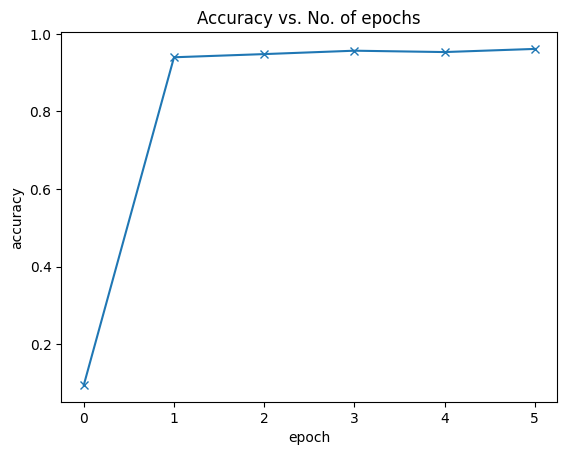

In [29]:
import matplotlib.pyplot as plt
accuracies = [val_metric] + metrics1
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');